## Step 1: Data Preparation
- Use the Kaggle email spam classification dataset.

## Step 2: Preprocess the Dataset
- Clean and tokenize the text.
- Convert the most common words for each email into embeddings using any standard method

In [55]:
!pip install numpy nltk==3.8.1 gensim pandas scikit-learn matplotlib wordcloud


In [56]:
from pyspeedy.files import *

df = pd.read_csv("../data/emails.csv")
df


,Email No.,the,to,ect,and,for,of,a,you,hou,...,connevey,jay,valued,lay,infrastructure,military,allowing,ff,dry,Prediction
0,Email 1,0,0,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Email 2,8,13,24,6,6,2,102,1,27,...,0,0,0,0,0,0,0,1,0,0
2,Email 3,0,0,1,0,0,0,8,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Email 4,0,5,22,0,5,1,51,2,10,...,0,0,0,0,0,0,0,0,0,0
4,Email 5,7,6,17,1,5,2,57,0,9,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5167,Email 5168,2,2,2,3,0,0,32,0,0,...,0,0,0,0,0,0,0,0,0,0
5168,Email 5169,35,27,11,2,6,5,151,4,3,...,0,0,0,0,0,0,0,1,0,0
5169,Email 5170,0,0,1,1,0,0,11,0,0,...,0,0,0,0,0,0,0,0,0,1
5170,Email 5171,2,7,1,0,2,1,28,2,0,...,0,0,0,0,0,0,0,1,0,1


In [57]:
df = df.drop(columns=["Email No."])
df.fillna(0, inplace=True)


In [58]:
# get ratio of spam to ham
spam_df = df[df["Prediction"] == 1]
non_spam_df = df[df["Prediction"] == 0]
print(f"Spam ratio: {len(spam_df)/len(df)}")
print(f"Non spam ratio: {len(non_spam_df)/len(df)}")


Spam ratio: 0.2900232018561485
Non spam ratio: 0.7099767981438515


In [59]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
import gensim.downloader as api
import numpy as np

# Download necessary NLTK data
nltk.download("punkt")
nltk.download("stopwords")

stopWords = set(stopwords.words("english"))
w2v_model = api.load("glove-twitter-25")
EMB_SIZE = 25


[nltk_data] Downloading package punkt to /home/lap14351/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lap14351/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [60]:
word_df = df.drop(["Prediction"], axis=1)
y = df["Prediction"]


In [61]:
def get_tokens(words):
    wordsFiltered = [w for w in words if w not in stopWords]
    return wordsFiltered


def get_average_embedding(tokens, model):
    embeddings = [model[word] for word in tokens if word in model]
    if embeddings:
        return sum(embeddings) / len(embeddings)
    else:
        return np.zeros(EMB_SIZE)


tokens = ["hello", "world"]
get_average_embedding(tokens, w2v_model)


array([-0.33384   ,  0.111968  ,  0.09174   , -0.10937035, -0.3119    ,
       -0.308575  ,  1.85465   ,  0.65563   , -0.49194002, -0.03528   ,
       -0.252135  ,  0.09525499, -3.7750502 ,  0.13482502, -0.30042   ,
       -0.240174  ,  0.14526   , -0.3426245 , -0.126445  ,  0.37805   ,
       -0.387455  , -0.51196504, -0.54485   , -0.044735  , -0.12309   ],
      dtype=float32)

In [62]:
# get the top_N that have the highest frequency
top_N = 100
df["embedding"] = None
for idx, row in word_df.iterrows():
    top_freq = row.sort_values(ascending=False)[:top_N]
    words = top_freq.index.tolist()
    tokens = get_tokens(words)
    emb = get_average_embedding(tokens, w2v_model)
    df.at[idx, "embedding"] = emb


## Step 3: Clustering Task
- Perform a clustering task on the email text data using the word embeddings
- Explain the choice of clustering algorithm and how the number of clusters was determined.

In [63]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

X = df["embedding"].tolist()


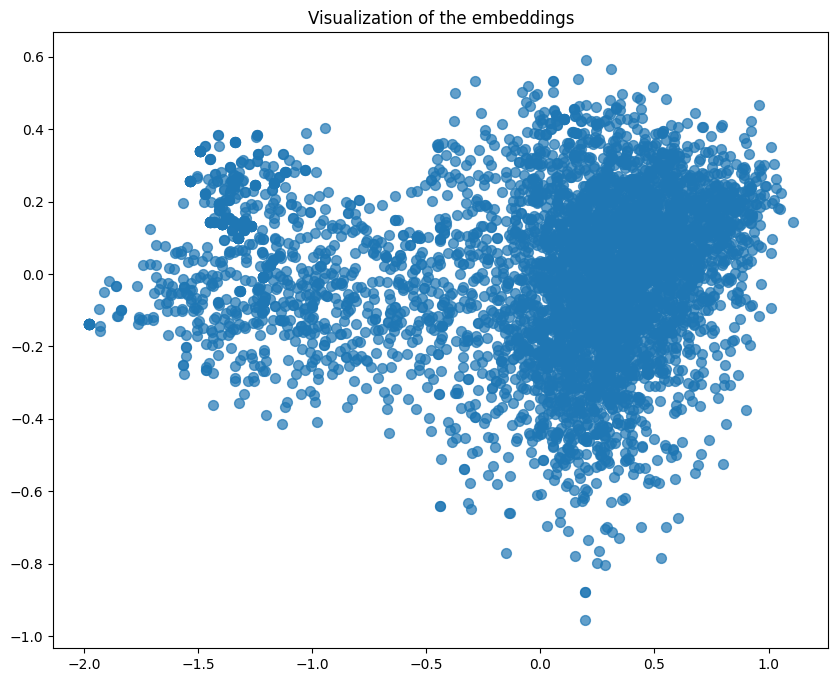

In [64]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

plt.figure(figsize=(10, 8))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], s=50, alpha=0.7)
plt.title("Visualization of the embeddings")
plt.show()


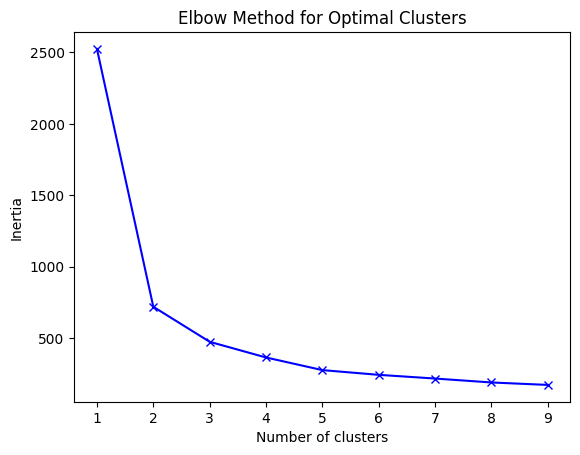

In [65]:
inertia = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_reduced)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, "bx-")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal Clusters")
plt.show()


In [66]:
# Use elbow method to determine the number of clusters
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df["cluster"] = kmeans.fit_predict(X)


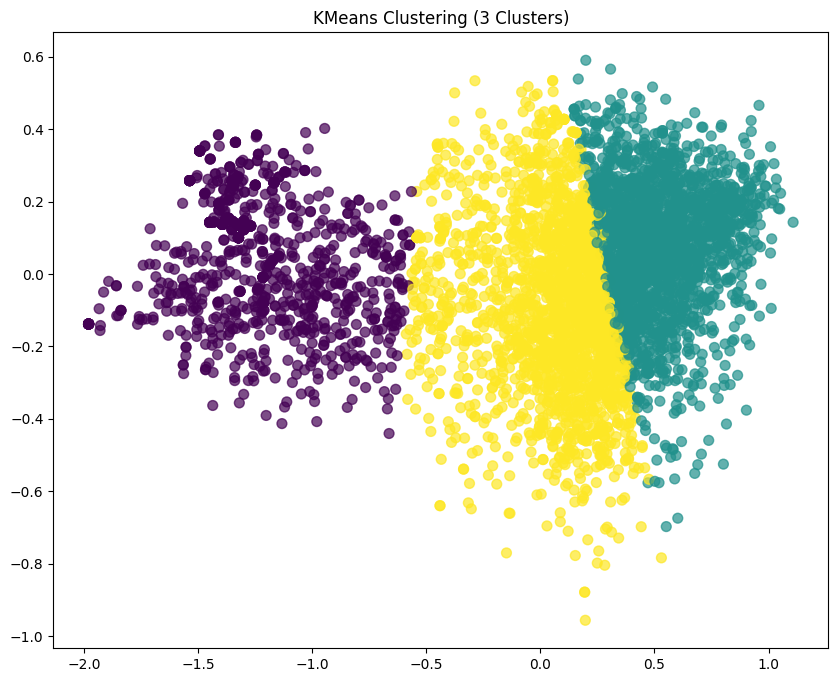

In [67]:
clusters = df["cluster"]

plt.figure(figsize=(10, 8))
plt.scatter(
    X_reduced[:, 0], X_reduced[:, 1], c=clusters, cmap="viridis", s=50, alpha=0.7
)
plt.title("KMeans Clustering (3 Clusters)")
plt.show()


## Step 4: Classification Task
- Build a classification model to differentiate between spam and regular emails using the embeddings or other extracted features.

In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)


In [69]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.88      0.93      0.90       739
           1       0.79      0.69      0.74       296

    accuracy                           0.86      1035
   macro avg       0.83      0.81      0.82      1035
weighted avg       0.85      0.86      0.85      1035



## Insights
- Identify the top common words that appear in both spam and regular emails. Discuss any insights derived from these words in relation to the model's performance.

In [70]:
from collections import Counter


def count_freq_words(df):
    count_dict = {}
    for idx, row in df.iterrows():
        for word, count in row.items():
            count_dict[word] = count + count_dict.get(word, 0)
    return Counter(count_dict)


In [71]:
spam_df = word_df[y == 1]
non_spam_df = word_df[y == 0]

spam_words = count_freq_words(spam_df)
non_spam_words = count_freq_words(non_spam_df)

# Find the most common words in each category
common_spam_words = spam_words.most_common(20)
common_non_spam_words = non_spam_words.most_common(20)

print("Most common words in spam emails:", common_spam_words)
print("Most common words in non-spam emails:", common_non_spam_words)


Most common words in spam emails: [('e', 151062), ('t', 109878), ('a', 105425), ('o', 103997), ('i', 100761), ('n', 90840), ('r', 89645), ('s', 83720), ('l', 58852), ('c', 54181), ('d', 47605), ('h', 44695), ('u', 42336), ('m', 38793), ('p', 36867), ('f', 29522), ('g', 27274), ('y', 25928), ('b', 25903), ('in', 22871)]
Most common words in non-spam emails: [('e', 287499), ('t', 202913), ('a', 181711), ('o', 180973), ('n', 157937), ('r', 145229), ('i', 136416), ('s', 132531), ('l', 101465), ('c', 100509), ('h', 93891), ('d', 78270), ('u', 71844), ('m', 70381), ('p', 53507), ('f', 45267), ('th', 45242), ('y', 43086), ('g', 39731), ('b', 39203)]


The most frequent words in both spam and non-spam emails are common single letters, like "e," "t," "a," "o," etc. These are essentially stop words or characters that appear frequently due to their common usage in the English language, rather than being indicative of whether an email is spam or not. This suggests that these words don’t provide much discriminative power for the classification model.

In [72]:
defined_stop_words = list(
    map(lambda x: x[0], count_freq_words(word_df).most_common(100))
)


In [73]:
from wordcloud import WordCloud


def get_corpus(words):
    corpus = []
    for w in words:
        if w in defined_stop_words:
            continue

        freq = words[w]
        corpus += [w] * freq
    return corpus


wc = WordCloud(width=500, height=500, min_font_size=10, background_color="white")


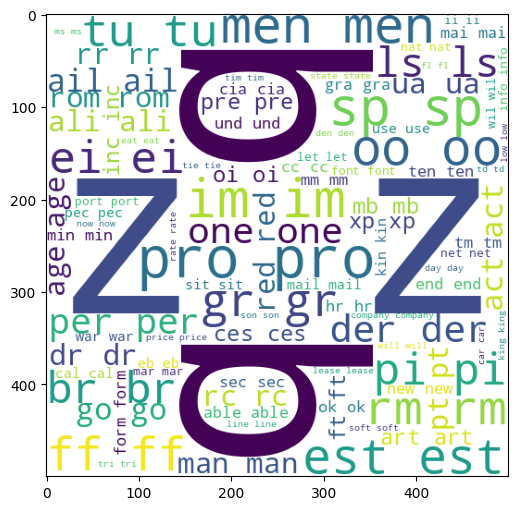

In [74]:
spam_wc = wc.generate(" ".join(get_corpus(spam_words)))
plt.figure(figsize=(15, 6))
plt.imshow(spam_wc)
plt.show()


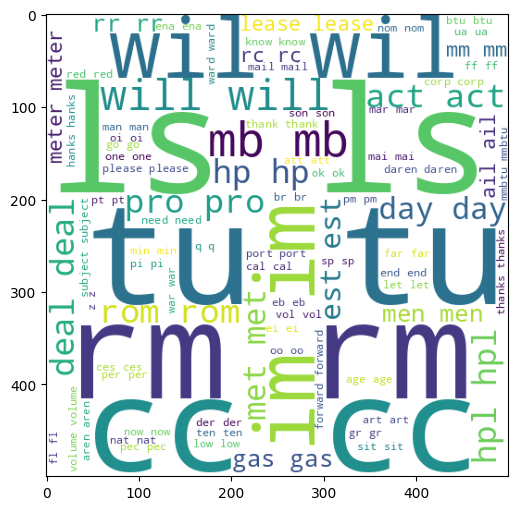

In [75]:
non_spam_wc = wc.generate(" ".join(get_corpus(non_spam_words)))
plt.figure(figsize=(15, 6))
plt.imshow(non_spam_wc)
plt.show()


In [76]:
def count_freq_words_drop_stop_words(df):
    count_dict = {}
    for idx, row in df.iterrows():
        for word, count in row.items():
            if word in defined_stop_words or word in stopWords:
                continue
            count_dict[word] = count + count_dict.get(word, 0)
    return Counter(count_dict)


for cluster in range(n_clusters):
    cluster_df = word_df[df["cluster"] == cluster]
    common_cluster_words = count_freq_words_drop_stop_words(cluster_df).most_common(20)
    print(f"Cluster {cluster} most common words:", common_cluster_words)


Cluster 0 most common words: [('hp', 1404), ('hpl', 1399), ('ls', 1078), ('xl', 612), ('xls', 606), ('nom', 374), ('att', 370), ('attached', 361), ('see', 344), ('file', 316), ('ua', 300), ('hplno', 270), ('tap', 266), ('teco', 266), ('tu', 240), ('act', 229), ('rc', 218), ('actual', 198), ('actuals', 191), ('hplo', 188)]
Cluster 1 most common words: [('pro', 5531), ('im', 5141), ('rm', 4987), ('q', 4869), ('z', 4811), ('men', 4685), ('tu', 4552), ('est', 4359), ('sp', 4268), ('oo', 4121), ('gr', 3823), ('ls', 3790), ('rom', 3673), ('ei', 3671), ('act', 3652), ('ff', 3626), ('wil', 3581), ('br', 3570), ('cc', 3551), ('mb', 3532)]
Cluster 2 most common words: [('ls', 1751), ('tu', 1589), ('deal', 1410), ('im', 1390), ('rm', 1298), ('cc', 1258), ('met', 1244), ('act', 1230), ('pro', 1177), ('mb', 1173), ('low', 1172), ('day', 1109), ('ei', 1109), ('lease', 1103), ('meter', 1091), ('rc', 1090), ('please', 1088), ('ff', 1062), ('rom', 1060), ('sp', 1051)]


## Next steps
- Try to remove more stop words
- Try larger word embeddings
- Try different classifiers
